In [2]:
import keras
from keras.models import load_model, Model
from keras.layers import Input
import numpy as np
import os, random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

% matplotlib inline

In [27]:
def deconstruct_model_v0(model_path):
    """Recreates the encoder and decoder portion of the autoencoder by loading in the autoencoder from the model_path.
    Note: This is explicitly assuming this is our first architecture we used for all datasets.
    Returns: encoder, decoder
    """
    autoencoder = load_model(model_path)
    autoencoder_in = Input(shape = (256,256,3), name = 'autoencoder_in')
    prev = autoencoder_in
    for layer in autoencoder.layers[:5]:
        prev = layer(prev)
    embeddings_layer = prev
    encoder = Model(autoencoder_in, embeddings_layer)
    encoder.compile(optimizer = "adam", loss = "binary_crossentropy")
    
    IMG_SHAPE = autoencoder.layers[5].input_shape[1:]
    decoder_in = Input(shape = IMG_SHAPE, name = 'decoder_in')
    prev = decoder_in
    for layer in autoencoder.layers[5:]:
        prev = layer(prev)
    autoencoder_output_layer = prev
    decoder = Model(decoder_in, autoencoder_output_layer)
    decoder.compile(optimizer = "adam", loss = "binary_crossentropy")
    
    return encoder, decoder

def load_hydra(model_paths):
    """Loads in encoder model, + 3 decoder heads. Assumes encoder_paths = [android, ios, web]
    Returns [encoder, android_head, ios_head, web_head]"""
    if len(model_paths) != 3:
        raise ValueError("must pass 3 paths, one for each model")
        
    # Get encoder from first model_path
    models = [load_model(ep) for ep in model_paths]
    android_model = models[0]
    encoder = Model(android_model.input, android_model.layers[-2].output)
    
    emb_in = Input(shape=(16, 16, 16))
    decoders = []
    for model in models:
        model = Model(emb_in, model.layers[-1](emb_in))
        decoders.append(model)
        
    return [encoder] + decoders

def load_points(data_dir):
    """Loads points from a data dir.
    IMG - numpy features of the image
    GUI - original text
    Points are tuples of form
    (img_path, gui_path)
    
    THE ONLY REASON WE ARE GUARANTEED TO HAVE MATCHING IMG/GUI pairs
    is that there are NO EXTRA files in data_dir. We then sort data_dir
    """
    imgs = []
    guis = []
    for path in sorted(os.listdir(data_dir)):
        if path.endswith('.npz'):
            imgs.append(data_dir + path)
        elif path.endswith('.gui'):
            guis.append(data_dir + path)
    points = list(zip(imgs, guis))
    return points

def unpack_point(point):
    img = np.load(point[0])['features']
    gui = open(point[1]).read()
    return img, gui

def sample_point(points):
    point = random.choice(points)
    return unpack_point(point)

keras.backend.clear_session()
MODEL = 'hydra'
BACKEND = 'ios'
DATASETS = ['android', 'ios', 'web']
if MODEL == 'standard':
    if BACKEND == 'ios':
        # Load from iOS directory
        model_path = "16x16x16coloriOSModel"
        data_dir = 'ios/training_features/'
    elif BACKEND == 'android':
        # Load from android
        model_path = 'model/autoencoders-v0/android.h5'
        data_dir = 'android/training_features/'
    elif BACKEND == 'web':
        # Load from web
        model_path = 'model/autoencoders-v0/web.h5'
        data_dir = 'web/training_features/'
    else:
        raise ValueError("Backend not understood: {}".format(BACKEND))
    encoder, decoder = deconstruct_model_v0(model_path)
    points = load_points(data_dir)
elif MODEL == 'hydra':
    encoder, android_head, ios_head, web_head = load_hydra(['{}-hydra-model'.format(x) for x in DATASETS])
    datasets = [load_points('{}/training_features/'.format(backend)) for backend in DATASETS]
    points = np.concatenate(tuple(datasets), axis=0)
print("Succesfully loaded.")

Succesfully loaded.


## Generate Interpolations Between Images

(256, 256, 3)
fig size: 72.0 DPI, size in inches [15. 15.]
C = 0.0021152793051308905
C = 0.0021152793051308905
C = 0.009529777859855648
C = 0.029748639919973674
C = 0.04333621610638905
C = 0.06592266295597848
C = 0.10277399624981565
C = 0.1034529937632267
C = 0.10901731614931698
C = 0.10989919361523759
C = 0.15656810446433866
C = 0.16034915036247877
C = 0.19325110319187555
C = 0.24652391070316027
C = 0.24997929649138428
C = 0.2664691266766662
C = 0.2922299452646767
C = 0.303058832861526
C = 0.3348034972679824
C = 0.346410719301082
C = 0.37163409412792636
C = 0.3945640694944308
C = 0.39636401282861333
C = 0.43096065640900727
C = 0.45940572806901725
C = 0.45969509435795375
C = 0.5131722838614563
C = 0.5479239468203939
C = 0.5566579473223968
C = 0.6007393403823498
C = 0.604285869352041
C = 0.6192196907575689
C = 0.6359352651191382
C = 0.648373559605115
C = 0.7370447547930605
C = 0.7424857995173683
C = 0.7470582616674982
C = 0.7551029069638089
C = 0.7712279462132238
C = 0.7915196034658225


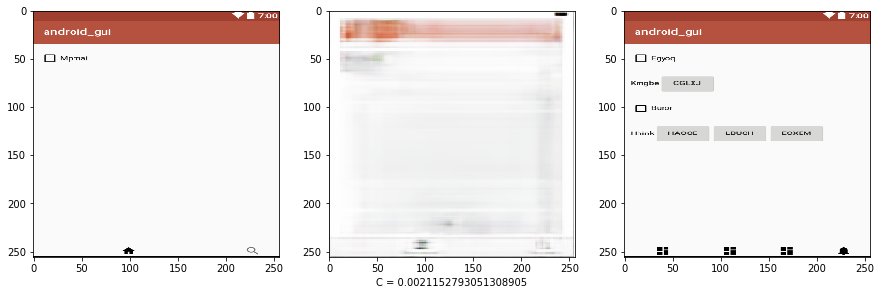

In [18]:
from pylab import rcParams
# set matplotlib rcParams to set fig size
rcParams['figure.figsize'] = 15, 15

def generate_decoder_values(pic_1, pic_2, size, encoder, decoder):
    """Interpolates between pic_1 and pic_2 by interpolating between their embeddings from the autoencoder.
    pic_1(np.array) - from sample_points
    pic_2(same as above)
    size(integer) - number of intermediate images
    """
    emb_1, emb_2 = [encoder.predict(np.expand_dims(pic, axis=0)) for pic in [pic_1, pic_2]]
    decoder_values = []
    # Sample random points between [0, 1], then sort them
    # Effectively taking random jumps from pic_1 to pic_2 as we interpolate between them
    # Looks decent though.
    C = np.sort(np.random.rand(size))
    for i in range(C.shape[0]):
        d_val = decoder.predict(C[i] * (emb_2 - emb_1) + emb_1)[0]
        decoder_values.append(d_val)
    print(decoder_values[0].shape)
    return decoder_values, C

def gif_range(pic_1, pic_2, num_imgs, encoder, decoder, save=True):
    """
    @author - Eli Bendersky
    @source - https://eli.thegreenplace.net/2016/drawing-animated-gifs-with-matplotlib/
    Makes a GIF that interpolates between pic_1 and pic_2 by sampling from the line between their embeddings.
    
    imgs(list of np.arrays): the intermediary sampled pics
    C(np.array): values sampled to interpolate
    pic_1/pic_2: np.array of actual image
    """
    imgs, C = generate_decoder_values(pic_1, pic_2, num_imgs, encoder, decoder)
    fig, ax = plt.subplots(1, 3)
    # fig.set_tight_layout(True)

    # Query the figure's on-screen size and DPI. Note that when saving the figure to
    # a file, we need to provide a DPI for that separately.
    print('fig size: {0} DPI, size in inches {1}'.format(
        fig.get_dpi(), fig.get_size_inches()))

    def update(i):
        label = 'C = {0}'.format(C[i])
        # Useful for debugging
        print(label)
        ax[0].imshow(pic_1)
        ax[1].imshow(imgs[i])
        ax[2].imshow(pic_2)
        ax[1].set_xlabel(label)
        return ax
    
    anim = FuncAnimation(fig, update, frames=np.arange(0, num_imgs), interval=70)
    if save:
        fname = '{}-decoder_predictions.gif'.format(BACKEND)
        anim.save(fname, dpi=80, writer='imagemagick')
        print("Saved to {}".format(fname))
    plt.show()
    plt.close(fig)

# This will be used for the GIF
NUM_IMGS = 50
img_1, gui_1 = sample_point(points)
img_2, gui_2 = sample_point(points)
gif_range(img_1, img_2, NUM_IMGS, encoder, decoder)

# King - Man + Woman = Queen

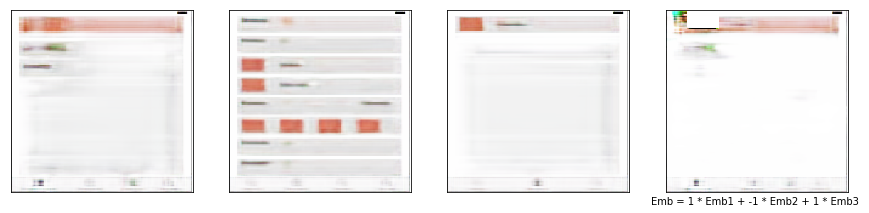

In [34]:
def plot_lin_comb(imgs, weights, encoder, decoder, fname=None, save=False):
    """Plots a combination of photos by creating linear combinations of their embeddings."""
    
    # Get the image embeddings to interpolate between
    embs = [encoder.predict(np.expand_dims(img, axis=0)) for img in imgs]
    size = len(embs)
    
    def predict(emb):
        return decoder.predict(emb)[0]
    
    fig, ax = plt.subplots(1, size + 1)
    pics = []
    for i in range(size):    
        pics.append(predict(embs[i]))

    pics = np.array(pics)
    new_emb = np.zeros(embs[0].shape)
    for i in range(size):
        new_emb += weights[i] * embs[i]
    
    new_pic = predict(new_emb)
    for i in range(size):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(pics[i])
    
    # The last axis displays the resultant combined image
    ax[-1].imshow(new_pic)
    label = 'Emb = '
    for i in range(size):
        label += '{0} * Emb{1} + '.format(weights[i], i + 1)
    label = label[:-2]
    ax[-1].set_xlabel(label)
    ax[-1].set_xticks([]), ax[-1].set_yticks([])
    if save:
        if not fname:
            fname = '{}_add_feature.png'.format(BACKEND)
        plt.savefig(fname)
    
# Example
img_1, gui_1 = sample_point(points)
img_2, gui_2 = sample_point(points)
img_3, gui_3 = sample_point(points)

plot_lin_comb([img_1, img_2, img_3], np.array([1, -1, 1]), encoder, ios_head)

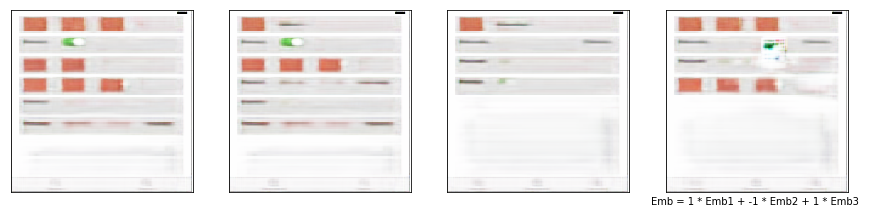

In [22]:
def find_most_similar_image(point, points, encoder):
    """Given an image, it finds the image with the most similar embedding. On the fly creates the embeddings
    for all the points in the dataset. Can be slow. Use with caution.
    """
    def cosine_similarity(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    def get_data(pt):
        """Returns the embedding of the point's image"""
        img, gui = unpack_point(pt)
        return encoder.predict(np.expand_dims(img, axis=0))[0]
    
    # Store our query embedding
    query_emb = get_data(point)
    flattened_emb = query_emb.flatten()
    
    best = 0
    arg_best = None
    # Find closest cosine similar image embedding in points pictures
    for pt in [pt for pt in points if point != pt]:
        emb_new = get_data(pt)
        sim = cosine_similarity(flattened_emb, emb_new.flatten())
        # Useful for debugging
#         print(sim)
        if sim > best and sim < 1.0:
            best, arg_best = sim, pt
    return best, arg_best

# Randomly sampling a point, subtracting its most similar sibling image, and adding a random image
# to create a new image
my_point = random.choice(points)
my_img, my_gui = unpack_point(my_point)
img2add, _ = sample_point(points) 

sim, close_point = find_most_similar_image(my_point, points, encoder)
close_img, _ = unpack_point(close_point)
plot_lin_comb([my_img, close_img, img2add], np.array([1, -1, 1]), encoder, decoder, fname='ios_add_feature.png', save=True)

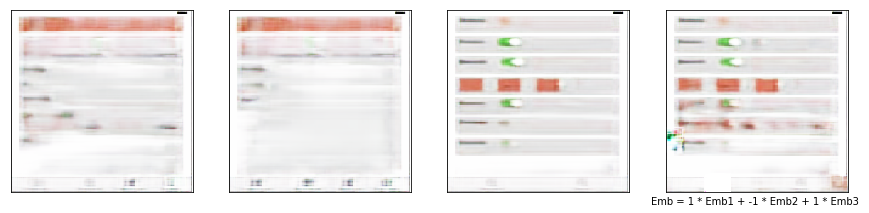

In [50]:
# Subtract 2 similar android photos, then add to ios
web_pt = random.choice(datasets[0])
web_img, _ = unpack_point(web_pt)
sim, close_web = find_most_similar_image(web_pt, datasets[0], encoder)
close_img, _ = unpack_point(close_web)

img2add, _ = sample_point(datasets[1])
plot_lin_comb([web_img, close_img, img2add], np.array([1, -1, 1]), encoder, ios_head, fname='add_web_diff_ios.png', save=True)

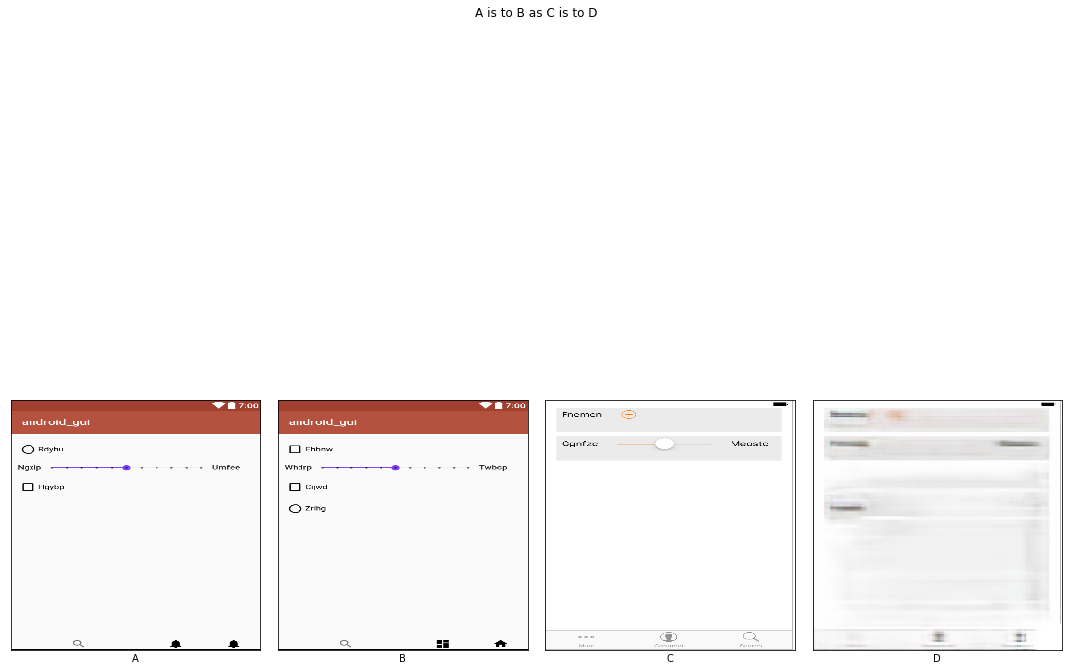

In [58]:
web_pt = random.choice(datasets[0])
web_img, _ = unpack_point(web_pt)
sim, close_web = find_most_similar_image(web_pt, datasets[0], encoder)
close_img, _ = unpack_point(close_web)

# img2add, _ = sample_point(datasets[1])

def encode(img):
    return encoder.predict(np.expand_dims(img, 0))[0]
fig, axes = plt.subplots(1,4)
axes[0].imshow(close_img)
axes[0].set_xlabel("A")
axes[1].imshow(web_img)
axes[1].set_xlabel("B")
axes[2].imshow(img2add)
axes[2].set_xlabel("C")
alg = encode(web_img) - encode(close_img) + encode(img2add)
new_img = ios_head.predict(np.expand_dims(alg, 0))[0]
axes[3].imshow(new_img)
axes[3].set_xlabel("D")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("A is to B as C is to D")
fig.tight_layout()
fig.savefig("add_web_to_ios.png")
plt.show(fig)
plt.close(fig)